In [4]:
import csv
import os
from os import path
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

In [623]:
# Define relative filepath in a subdirectory
file_path = "data/taylor_album_songs.csv"
data_directory = 'data'
os.makedirs(data_directory, exist_ok=True)

# Read file
data_taylor_album_songs = pd.read_csv(file_path)

# Clean data and create a new csv
columns_to_drop = ['artist_name', 'artist_id', 'album_id', 'album_release_year', 'album_release_date_precision', 'album_type', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'track_id', 'track_number', 'type', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'disc_number', 'duration_ms', 'track_preview_url', 'track_uri', 'external_urls.spotify', 'key_name', 'mode_name', 'key_mode', 'track_href', 'is_local', 'analysis_url']
data_taylor_album_songs.drop(columns=columns_to_drop, axis=1, inplace=True)
values_to_keep = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", "Red (Taylor's Version)", "1989 (Deluxe)", "reputation", "Lover", "folklore (deluxe version)", "evermore (deluxe version)", "Midnights (3am Edition)"]
data_taylor_album_songs = data_taylor_album_songs[data_taylor_album_songs['album_name'].isin(values_to_keep)]

cleaned_album_data = data_taylor_album_songs
cleaned_album_data.rename(columns = {'album_release_date': 'Release Date', 'explicit': 'Explicit', 'track_name': 'Song Title', 'album_name': 'Album', 'lyrics': 'Lyrics' }, inplace=True)
cleaned_album_data = cleaned_album_data[['Album', 'Release Date', 'Explicit', 'Song Title']]
songs_to_drop = ["Speak Now (Taylor’s Version) [Prologue]", "A Message From Taylor", "Taylor Swift’s First Phone Call With Tim McGraw", "I Know Places (Voice Memo)", "I Wish You Would (Voice Memo)",  "Blank Space (Voice Memo)", "If You’re Anything Like Me [Poem]", "Why She Disappeared [Poem]", "Reputation [Prologue]", "Evermore [Liner Notes]", "​​folklore [Foreword]", "Forever & Always (Piano Version) [Taylor’s Version]", "Love Story (Taylor’s Version) [Elvira Remix]",  "State Of Grace (Acoustic Version) (Taylor’s Version)"]
rows_to_drop = cleaned_album_data['Song Title'].isin(songs_to_drop)
cleaned_album_data['Album'].replace({'Taylor Swift': 'Taylor Swift (Deluxe)'}, inplace=True)

#
cleaned_album_data.to_csv('data/cleaned_album_data.csv', index=False)


C:\Users\jlwoo\AppData\Local\Temp\ipykernel_26616\3530569326.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_album_data['Album'].replace({'Taylor Swift': 'Taylor Swift (Deluxe)'}, inplace=True)


In [617]:
# Define relative filepath in a subdirectory
file_path = "data/taylor_lyrics.csv"

# Read file
data_taylor_lyrics = pd.read_csv(file_path)

#Clean data and create new csv
cleaned_lyric_data = data_taylor_lyrics

#Remove duplicate tracks and spoken/non-songs
songs_to_drop = ["Speak Now (Taylor’s Version) [Prologue]", "A Message From Taylor", "Taylor Swift’s First Phone Call With Tim McGraw", "I Know Places (Voice Memo)", "I Wish You Would (Voice Memo)",  "Blank Space (Voice Memo)", "If You’re Anything Like Me [Poem]", "Why She Disappeared [Poem]", "Reputation [Prologue]", "Evermore [Liner Notes]", "folklore [Foreward]", "Forever & Always (Piano Version) [Taylor’s Version]", "Love Story (Taylor’s Version) [Elvira Remix]",  "State Of Grace (Acoustic Version) (Taylor’s Version)"]
rows_to_drop = cleaned_lyric_data['Song Title'].isin(songs_to_drop)
columns_to_drop = ["Featured Artists"]
data_taylor_lyrics.drop(columns=columns_to_drop, axis=1, inplace=True)
cleaned_lyric_data = cleaned_lyric_data[~rows_to_drop]

cleaned_lyric_data.to_csv('data/cleaned_lyric_data.csv', index=False)

In [620]:
# Reload cleaned data
cleaned_album_data = pd.read_csv('data/cleaned_album_data.csv')
cleaned_lyric_data = pd.read_csv('data/cleaned_lyric_data.csv')

# Merge
merged_data = cleaned_lyric_data.merge(
    cleaned_album_data[['Album', 'Release Date', 'Song Title', 'Explicit']],
    on=['Album', 'Release Date', 'Song Title'],
    how='left'
)

# Fill NaN values in 'Explicit' with values from cleaned_album_data
merged_data['Explicit'].fillna(cleaned_album_data['Explicit'], inplace=True)

# Rearrange columns
column_order = ['Album', 'Release Date', 'Song Title', 'Explicit', 'Lyrics']
merged_data = merged_data[column_order]

# Save to a new CSV file
merged_data.to_csv('data/merged_taylor_data.csv', index=False)

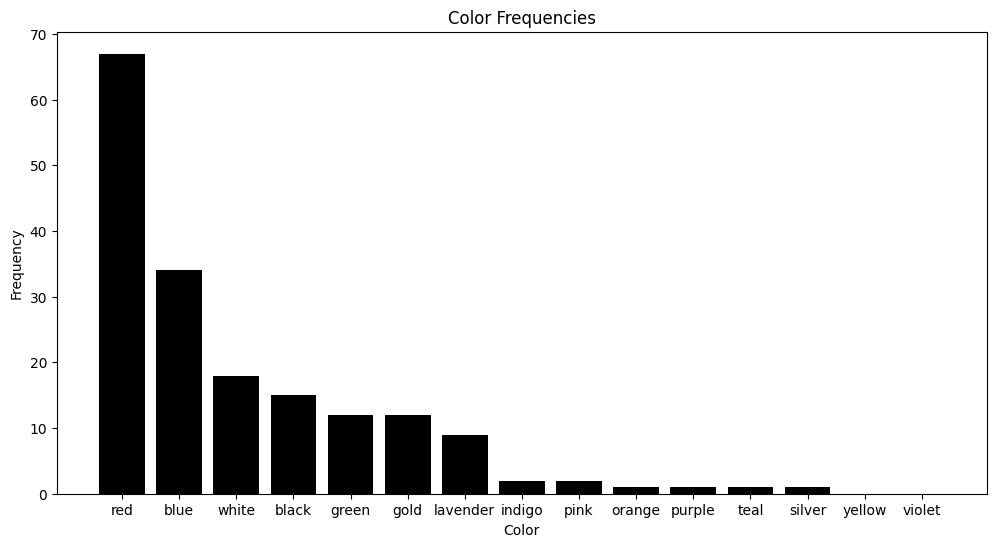

In [24]:
# Load the cleaned lyric data
cleaned_lyric_data = pd.read_csv('data/cleaned_lyric_data.csv')

# Combine all lyrics into a single string
all_lyrics = ' '.join(cleaned_lyric_data['Lyrics'].dropna())

# Tokenize the words
tokens = word_tokenize(all_lyrics)

# Specify words of interest
words_of_interest = ['red', 'orange', 'blue', 'green', 'yellow', 'violet', 'indigo', 'purple', 'pink', 'white', 'black', 'lavender', 'teal', 'gold', 'silver']
word_frequencies = {word: freq_dist[word] for word in words_of_interest}
sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True))

# Specify color of bars in graph

colors = ['black']

# Change figure size
plt.figure(figsize=(12, 6))

# graph
plt.bar(sorted_word_frequencies.keys(), sorted_word_frequencies.values(), color =colors)
plt.title('Color Frequencies')
plt.xlabel('Color')
plt.ylabel('Frequency')
plt.show()



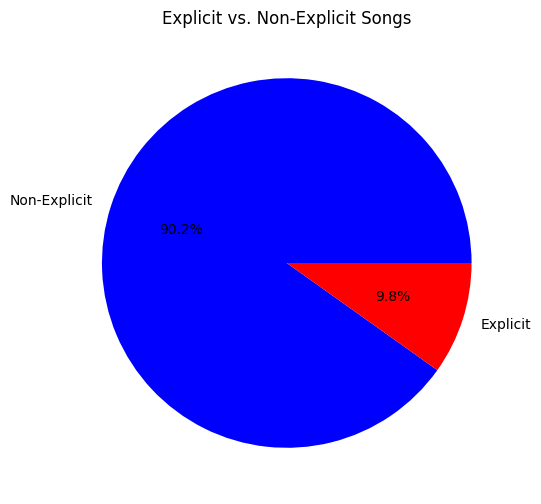

In [32]:
# Load data
merged_data = pd.read_csv('data/merged_taylor_data.csv')

# Count the number of True and False values in the "Explicit" column
explicit_counts = merged_data['Explicit'].value_counts()
# Map true/false values to explicit/non-explicit
merged_data['Explicit_Label'] = merged_data['Explicit'].map({True: 'Explicit', False: 'Non-Explicit'})

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(explicit_counts, labels=['Non-Explicit', 'Explicit'], autopct='%1.1f%%', colors=['blue', 'red'])
plt.title('Explicit vs. Non-Explicit Songs')
plt.show()